# Plotting using cartopy

---

# What does this cover?

1. Basic map creation
2. Opening reanalysis data and plotting a time mean
3. Opening Nino 3.4 index data and plotting precipitation teleconnections

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import xarray

import cartopy
import cartopy.util
import cartopy.io.shapereader

import pandas
import datetime

% matplotlib inline

# (1) Creating a cartopy map

## Cartopy works with the `fig` and `ax` syntax

* The main difference:  cartopy also requires a "crs" (coordinate reference system) class to be specified

* **Issue:**  Sometimes (often?), your data will be in a different projection than the map you want to use to display it

* **Solution:**  Create separate projection objects using what you know about your data and the map you desire to plot


## Steps to create a cartopy map:

1.  Specify the projection of the MAP and DATA separately (`map_crs`, `data_crs`)

2.  Create the `Figure` and `Axes`, and specify the `map_crs` using the `projection` keyword

3.  When you add contours or data to the map, specify `transform = data_crs`

#### See the cartopy documentation for projection (crs) options [HERE](http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)

Plate Carrée is the typical cylindrical equidistant projection

In [2]:
data_crs = cartopy.crs.PlateCarree() # specify the data set projection (reanalysis typically Plate Carrée)
map_crs = cartopy.crs.PlateCarree() # create projection for map, un-comment lines below for other options

#### Attaching your projection to an `Axes` object

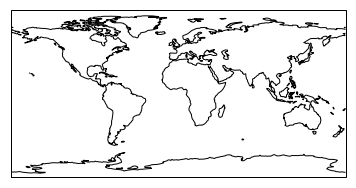

In [3]:
map_crs = cartopy.crs.PlateCarree()
#map_crs = cartopy.crs.Robinson()
#map_crs = cartopy.crs.Mollweide()
#map_crs = cartopy.crs.PlateCarree(central_longitude=180)
#map_crs = cartopy.crs.InterruptedGoodeHomolosine()

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=map_crs)
ax.coastlines()

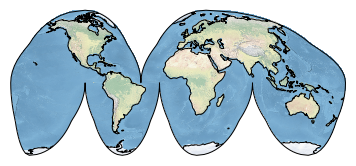

In [4]:
#map_crs = cartopy.crs.PlateCarree()
#map_crs = cartopy.crs.Robinson()
#map_crs = cartopy.crs.Mollweide()
#map_crs = cartopy.crs.PlateCarree(central_longitude=180)
map_crs = cartopy.crs.InterruptedGoodeHomolosine()

fig, ax = plt.subplots(1,1, subplot_kw={'projection':map_crs}) # specify projection as dictionary in subplot_kw
ax.coastlines()

ax.stock_img()

#### Use `ax.set_extent()` to zoom in

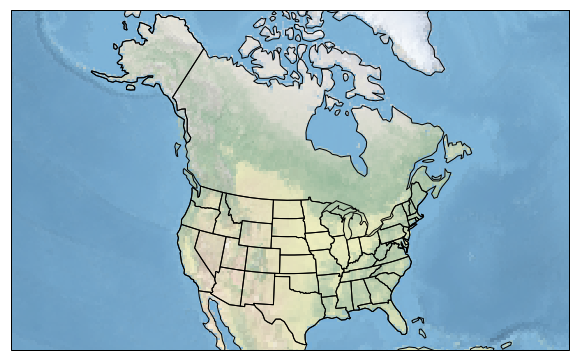

In [5]:
map_crs = cartopy.crs.LambertConformal(central_longitude=260, central_latitude=40, standard_parallels=(25,75))

fig, ax = plt.subplots(1,1, subplot_kw={'projection':map_crs})
fig.set_size_inches(10,8)
ax.stock_img()

# set extent of map using [lon_lo, lon_hi, lat_lo, lat_hi]
# note the crs keyword
ax.set_extent([210,310,25,75], crs=cartopy.crs.PlateCarree())

# add country borders (110m resolution defaults)
ax.add_feature(cartopy.feature.BORDERS)

# add states/provinces by first importing the shape file from Natural Earth
states_provinces = cartopy.feature.NaturalEarthFeature(category='cultural',\
                                                       name='admin_1_states_provinces_lakes_shp',\
                                                       scale='110m',\
                                                       facecolor='none')
ax.add_feature(states_provinces, edgecolor='0')

ax.coastlines()

#### Create panel plots using the same syntax you would in regular matplotlib

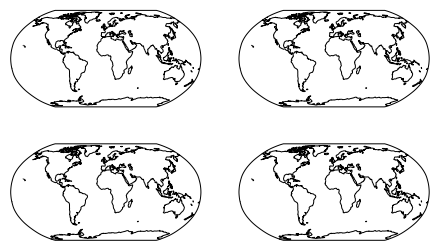

In [6]:
map_crs = cartopy.crs.Robinson()

fig, ax_array = plt.subplots(2,2,subplot_kw={'projection':map_crs})
ax1,ax2,ax3,ax4 = ax_array.flatten()

fig.set_size_inches(7.5,4.5)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

# (2) GPCP reanalysis preciptiation plots

In [3]:
precip_dataset = xarray.open_dataset('precip.mon.mean.nc')

precip = precip_dataset['precip']
precip_values = precip.values # extract values from xarray dataset
pr_lat = precip_dataset['lat']
pr_lon = precip_dataset['lon']

pr_time = precip_dataset['time']
pr_time_datetime = pandas.to_datetime(pr_time.values) # create datetime array for times

In [8]:
precip_dataset
#print(pr_time)
pr_time_datetime.shape

(469,)

#### Note the precipitation time axis has been converted to a `datetime` object

This makes plotting times and subsetting days/months/years easier

In [9]:
print(pr_time_datetime[0])
t = pr_time_datetime[0]

print(t.year)
print(t.month)
print(t.day)
print(t.hour, t.minute, t.second)

1979-01-01 00:00:00
1979
1
1
0 0 0


#### Calculate time mean of precipitation (mean across the first axis)

In [10]:
precip_time_mean = precip_values.mean(axis=0)

#### Plot this field with a map overlaid

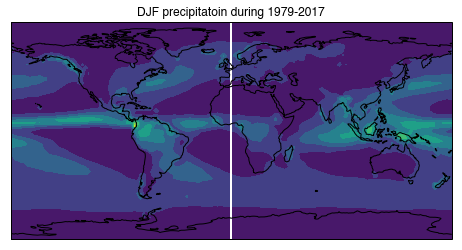

In [11]:
map_crs = cartopy.crs.PlateCarree()
data_crs = cartopy.crs.PlateCarree() # typical for global reanalysis data sets

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection=map_crs) # specify map projection
ax.coastlines()
ax.set_title('DJF precipitatoin during 1979-2017')

ax.contourf(pr_lon, pr_lat, precip_time_mean, transform=data_crs) # whenever plotting data, specify its projection

#### Add cyclic point (where it wraps from 360º to 0º longitude)

Note the colorbar below:  Easy to create one quickly, but doesn't fit the plot that well

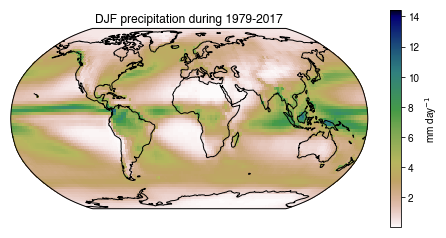

In [12]:
#map_crs = cartopy.crs.PlateCarree()
map_crs = cartopy.crs.Robinson()
#map_crs = cartopy.crs.InterruptedGoodeHomolosine()
#data_crs = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection=map_crs)
ax.coastlines()

ax.set_title('DJF precipitation during 1979-2017')

precip_cyclic, pr_lon_cyclic = cartopy.util.add_cyclic_point(precip_time_mean, pr_lon)

contour_plot = ax.pcolormesh(pr_lon_cyclic, \
                             pr_lat, \
                             precip_cyclic, \
                             transform=data_crs, \
                             cmap='gist_earth_r')

cbar = plt.colorbar(contour_plot, label='mm day$^{-1}$')

#### More advanced:  Change font sizes, color bar, add contour lines to emphasizes contours

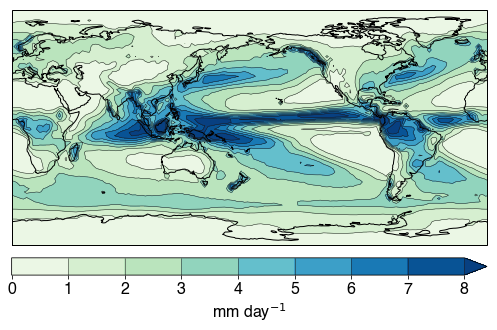

In [13]:
my_fontsize = 16

map_crs = cartopy.crs.PlateCarree(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection=map_crs)
ax.coastlines()

precip_cyclic, pr_lon_cyclic = cartopy.util.add_cyclic_point(precip_time_mean, pr_lon)

contour_plot = ax.contourf(pr_lon_cyclic, \
                           pr_lat, \
                           precip_cyclic, \
                           transform=data_crs, \
                           cmap='GnBu', \
                           levels=np.arange(0,8.1,1),\
                           extend='max')
contour_lines = ax.contour(pr_lon_cyclic, \
                           pr_lat, \
                           precip_cyclic, \
                           transform=data_crs, \
                           levels=np.arange(0,8.1,1),\
                           colors='0.1',\
                           linewidths=0.5)

fig.tight_layout()

ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar_ax.tick_params(labelsize=my_fontsize)
cbar.set_label('mm day$^{-1}$', fontsize=my_fontsize)
cbar.add_lines(contour_lines)

#fig.savefig('annual_mean_precip.png', dpi=600, bbox_inches='tight')

# (3) Open Nino 3.4 SST data, calculate precip teleconnections, map them

In [16]:
sst_file = 'ersst4.nino.mth.81-10.ascii.txt'
sst_dataframe = pandas.read_table(sst_file, delim_whitespace=True)
sst_data = sst_dataframe.values

sst_dataframe.describe()
#print(sst_dataframe)

YR         MON     NINO1+2        ANOM       NINO3  \
count   795.000000  795.000000  795.000000  795.000000  795.000000   
mean   1982.626415    6.483019   23.162918   -0.251560   25.897333   
std      19.137052    3.459103    2.205630    1.000732    1.229816   
min    1950.000000    1.000000   19.190000   -2.750000   22.830000   
25%    1966.000000    3.000000   21.305000   -0.910000   24.930000   
50%    1983.000000    6.000000   22.950000   -0.400000   25.900000   
75%    1999.000000    9.000000   25.080000    0.225000   26.855000   
max    2016.000000   12.000000   29.120000    4.090000   29.240000   

           ANOM.1      NINO4      ANOM.2     NINO3.4      ANOM.3  
count  795.000000  795.00000  795.000000  795.000000  795.000000  
mean    -0.183270   28.47644   -0.162403   27.012164   -0.149811  
std      0.840972    0.64581    0.611824    0.926949    0.819713  
min     -2.280000   26.54000   -1.890000   24.520000   -2.260000  
25%     -0.760000   28.05500   -0.580000   26.375000   -0.750000  
50%     -0.240000   28.51000   -0.130000   27.070000   -0.190000  
75%      0.265000   28.99500    0.290000   27.660000    0.350000  
max      3.100000   29.99000    1.300000   29.140000    2.370000

#### Pull out 1st, 2nd, and 9th columns (years, months, Nino3.4)

In [15]:
sst_years = sst_data[:,0]
sst_months = sst_data[:,1]
sst_nino34 = sst_data[:,8]
sst_nino34_centered = sst_nino34 - sst_nino34.mean()

ntime = sst_years.size
sst_time_datetime = [datetime.date(int(sst_years[i]), int(sst_months[i]), 15) for i in range(ntime)]

### Plot the Nino 3.4 index
For example, matplotlib will accept an array of datetime objects as an axis argument

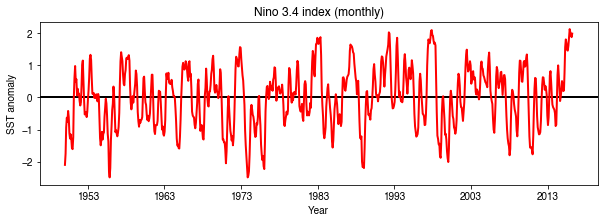

In [16]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)

ax.plot(sst_time_datetime, sst_nino34_centered, color='red', lw=2) # a higher zorder means the line will sit over others
ax.set_xlabel('Year')
ax.set_ylabel('SST anomaly')
ax.set_title('Nino 3.4 index (monthly)')
ax.axhline(y=0, color='black', ls='-', lw=2, zorder=1)

#### Extract all DJF data between 1980 and 2011

In [18]:
# pull out nino34 and precip between 1980 and 2010
sst_DJF_indices = [i.year in range(1980,2011) and i.month in [12,1,2] for i in sst_time_datetime]
#print(sst_DJF_indices)
precip_DJF_indices = [i.year in range(1980,2011) and i.month in [12,1,2] for i in pr_time_datetime]

sst_DJF_1980_2010 = sst_nino34[sst_DJF_indices]
precip_DJF_1980_2010 = precip.values[precip_DJF_indices,:,:]

#### Use `scipy.stats.linregress()` to regress precipitation onto the Nino 3.4 index

In [18]:
# do regressions of precip ONTO nino34

# empty arrays to store pvals, slope of regression
pvals_array = np.zeros((pr_lat.size,pr_lon.size)) # 72x144 (2.5 degree grid boxes)
slope_array = np.zeros((pr_lat.size,pr_lon.size))

# embedded loop going through each grid point and calculating the slope and pvalues
for j in range(pr_lat.size):
    for k in range(pr_lon.size):
        slope_array[j,k], tmp, tmp, pvals_array[j,k], tmp = \
        scipy.stats.linregress(sst_DJF_1980_2010, precip_DJF_1980_2010[:,j,k])

Text(0.5,1,'DJF precip. regressed\nonto Niño 3.4 (1980-2010)')

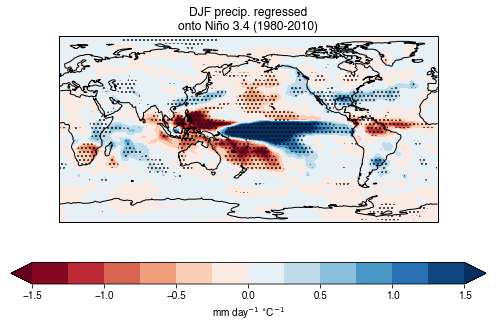

In [19]:
map_crs = cartopy.crs.PlateCarree(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(7,4))

ax = fig.add_subplot(111, projection=map_crs)
ax.coastlines()

slope_cyclic, pr_lon_cyclic = cartopy.util.add_cyclic_point(slope_array, coord=pr_lon, axis=1)
pvals_cyclic, pr_lon_cyclic = cartopy.util.add_cyclic_point(pvals_array, coord=pr_lon, axis=1)

contour_plot = ax.contourf(pr_lon_cyclic, \
                           pr_lat, \
                           slope_cyclic, \
                           levels=np.arange(-1.5,1.6,0.25), \
                           cmap='RdBu', extend='both', \
                           transform=data_crs)

stippling_plot = ax.contourf(pr_lon_cyclic, \
                             pr_lat, \
                             pvals_cyclic, \
                             levels=[0.0,0.05,1.0], \
                             hatches=['...',''], \
                             colors='None', \
                             transform=data_crs)

fig.tight_layout()

colorbar= plt.colorbar(contour_plot, orientation='horizontal')
colorbar.set_label('mm day$^{-1}$ $^{\circ}$C$^{-1}$')

ax.set_title('DJF precip. regressed\nonto Niño 3.4 (1980-2010)')

#fig.savefig('precip_teleconnections.png', dpi=300, bbox_inches='tight')